# Plotting Observed Data and Modeled Results

This notebook contains code to plot model results for the inagural MEDS Public Presentation held May 26, 2022 on the project: `An open-source pipeline for remote sensing of crop yields: a Zambia case study`.

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import plotly.express as px
import geopandas
import pickle
import math
import seaborn as sns

from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

### Set Global Options for plot fontsize

In [2]:
# fontsize
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

# plt.rcParams.update({'font.size': 10})

#### HTML layout

In [3]:
%%html
<style>
table {float:left}
</style>

### Model parameters

Appriximately 10 parameters were varied during model optimization. Our best performing model used Landsat 8, bands 1-7, and covered the growing season. A ful list of parameters for our top model is listed below.

Parameters      | Value
-------------   | ------------- 
Satellite       | Landsat 8  
Bands           | 1-2-3-4-5-6-7
Years           | 2014-2018
Months          | 4-9
Number of points| 15,000
Crop mask       | None
Weighted averge | None
Train **n**     | 272
Test **n**      | 68

In [4]:
country_code = "ZMB"
num_features = 1000
data_dir = "/capstone/cropmosaiks/data"

## Calculate Yields in metric tons

The code below imports the Zambia shapefile and crop yield data. 

### Import Zambia shapefile

In [31]:
country_shp = geopandas.read_file(f'{data_dir}/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(figsize = (12,10), linewidth = 1, edgecolor = 'black' )
# country_shp.head(2)

(72, 1)

### Import Zambia Crop Data

In [33]:
crop_df_full = pd.read_csv(data_dir+'/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df_full.rename({'yield_mt': 'yield_mt_ha'}, axis=1, inplace=True)
crop_df_full['yield_mt'] = crop_df_full['yield_mt_ha'] * crop_df_full['area_planted']
crop_df_full['data_type'] = 'ground_truth'
crop_df_full.district = crop_df_full.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)

# calculate log yield
crop_df_full['log_yield'] = np.log10(crop_df_full.yield_mt_ha.to_numpy() + 1)

# set index
crop_df = crop_df_full
crop_df = crop_df.set_index('district')

# calculate average hectare of crop area
avg_crop_area = crop_df_full['area_planted'].mean()

district_df = crop_df.groupby('year').agg({'yield_mt': 'sum'})
district_df = district_df.reset_index()

# crop_df_full.head(2)

## Join ground-truthed crop yields and Zambia shapefile

We'll convert to GeoDataFrame

In [32]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)
country_crop = country_crop[country_crop.year >= 2014]
#country_crop.head(2)

# Plot individual year (Observed Data)

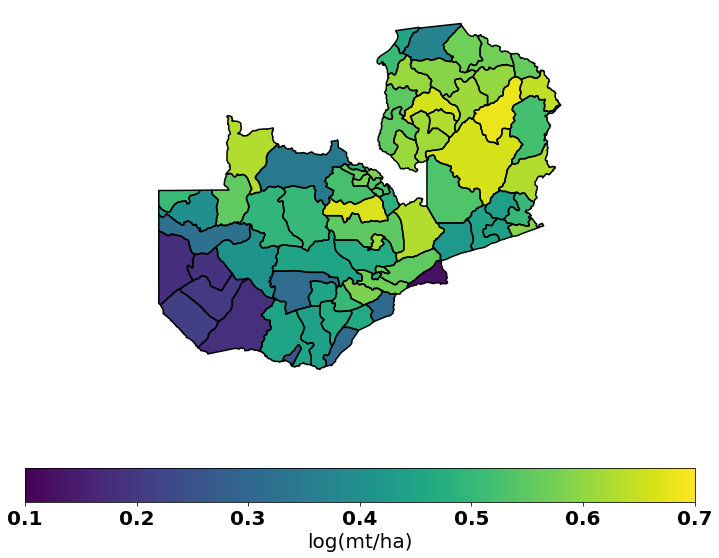

In [10]:
crop_year = 2017

max_val=0.7
min_val=0.1

fig, ax = plt.subplots(figsize = (12,10))
country_crop[country_crop.year == crop_year].plot(
    column = "log_yield",
    legend = True,
    linewidth =1,
    ax = ax,
    legend_kwds = {'label': 'log(mt/ha)','orientation': 'horizontal'},
    norm=colors.Normalize(vmin=min_val, vmax=max_val)
)

country_shp.boundary.plot(ax = ax, edgecolor = "black")
plt.axis('off')

# changes default paramaters for font size
# fig.rcParams.update({'font.size': 22})

plt.savefig(f'images/{crop_year}_yield_CSO_data.png', dpi=300, transparent=True)

# Import high-resolution yield predictions

In [11]:
pred_high_res = pd.read_feather('data/results/pred_features_all.feather')
# pred_high_res.head()

year district  yield_prediction       0_4       0_5       0_6       0_7  \
0  2014   Kalabo               NaN  2.796088  2.169905  1.877239  1.058961   
1  2015   Kalabo               NaN  1.746281  1.908137  1.600143  1.195653   
2  2016   Kalabo               NaN  2.224097  2.074300  1.898633  1.076144   
3  2017   Kalabo               NaN  2.587581  3.022594  2.533386  2.202421   
4  2018   Kalabo               NaN  2.563579  2.783937  1.787531  2.116021   

        0_8       0_9       1_4  ...     998_8     998_9     999_4     999_5  \
0  0.874885  1.043665  3.728270  ...  2.574691  2.577646  6.166853  6.677697   
1  1.250450  1.112692  4.794718  ...  2.901912  2.806297  8.181073  9.834212   
2  1.037122  0.774001  5.436888  ...  2.808548  2.704272  9.098929  9.766782   
3  1.629587  1.223843  4.188748  ...  2.788114  2.703153  6.933536  7.877261   
4  1.039855  1.102192  3.424892  ...  2.595296  2.588604  5.816585  6.415036   

      999_6     999_7      999_8     999_9        lon        lat  
0  8.116331  8.290212   8.556185  8.622112  22.000378 -15.233847  
1  9.577337  9.478734  10.115788  9.887067  22.000378 -15.233847  
2  9.202447  9.824132   9.903685  9.594785  22.000378 -15.233847  
3  8.821350  9.190662   9.328294  9.175184  22.000378 -15.233847  
4  7.585889  9.062753   8.564720  8.549556  22.000378 -15.233847  

[5 rows x 6005 columns]

In [12]:
# convert to geodataframe
pred_features = geopandas.GeoDataFrame(pred_high_res)

# convert lat & lon columns to a new geometry column
pred_features = geopandas.GeoDataFrame(pred_features, geometry=geopandas.points_from_xy(pred_features.lon, pred_features.lat))

# set the crs to WGS84
pred_features = pred_features.set_crs('epsg:4326')

## Plot Individual Year High-Resolution (Modeled Data)

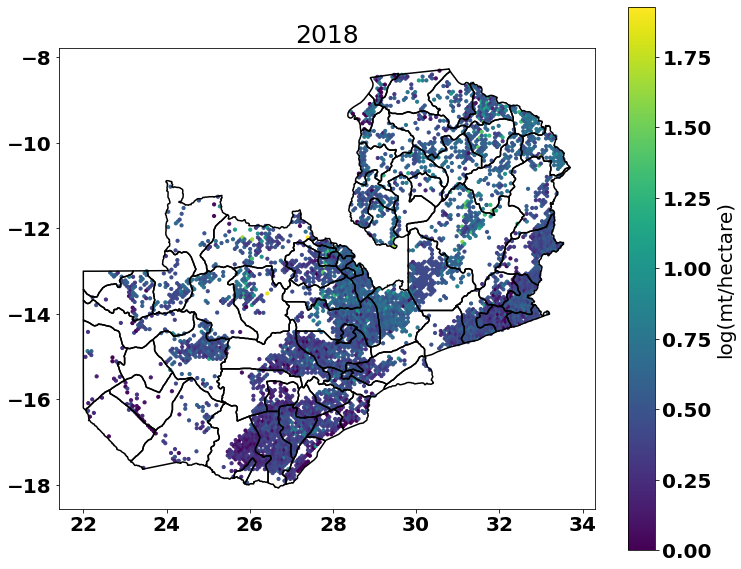

In [14]:
prediction_year = 2018

fig, ax = plt.subplots(figsize = (12,10))
pred_features[pred_features.year == prediction_year].plot(
    column = "yield_prediction",
    s=10,
    legend = True,
    figsize= (12, 10),
    ax = ax,
    legend_kwds = {'label': 'log(mt/hectare)','orientation': 'vertical'},
)
ax.set_title(f'{prediction_year}', fontsize=25)

#plt.legend(facecolor='k', labelcolor='w', labels = 'yield_predictions')

country_shp.boundary.plot(ax = ax, edgecolor = "black")

plt.savefig(f'images/yield_predictions_{prediction_year}.png', dpi=300, transparent=True)

## Import Modeled Data (District-level)

In [34]:
# pred_df_full = geopandas.read_file('data/results/pred_features.gpkg')
pred_summary_full = geopandas.read_file('data/results/pred_features_summary.gpkg')
pred_summary_full['data_type'] = 'predictions'
pred_summary_full.rename({'yield_prediction': 'pred_log_yield_ha'}, axis=1, inplace=True)

# filter for crop overlap years
pred_summary_match = pred_summary_full[pred_summary_full.year >= 2014]
pred_summary_match = pred_summary_match[pred_summary_match.year <= 2018]


# filter for prediction years
pred_summary_future = pred_summary_full[pred_summary_full.year >= 2019]

# pred_summary_full

Merge district-level predictions with observed yield data 

In [30]:
pred_crop = pred_summary_match.merge(crop_df_full, on = ['year', 'district'])
pred_crop.rename({'data_type_x': 'data_type'}, axis=1, inplace=True)
pred_crop.drop('geometry', axis=1, inplace=True)

# pred_crop['yield_mt_ha'] = 10 ** pred_crop['pred_log_yield_ha']
# pred_crop['yield_mt'] = pred_crop['area_planted'] * pred_crop['yield_mt_ha']

#pred_crop = pred_crop[['district','year', 'yield_mt', 'data_type']]
pred_crop = pred_crop.set_index('district')

pred_crop.head(3)

year  pred_log_yield_ha    data_type  area_planted  area_harvested  \
district                                                                       
Chadiza   2014           0.515994  predictions     25395.400       22956.746   
Chadiza   2015           0.462944  predictions     25378.742       21824.945   
Chadiza   2016           0.382753  predictions     21652.461       13567.917   

          expected_pn  yield_mt_ha      sales  basal_fert  top_dressing  \
district                                                                  
Chadiza     61134.535     2.407307  30788.762   3219.1348     3246.9150   
Chadiza     51344.656     2.023136  21797.336   3128.9385     3177.0427   
Chadiza     40629.262     1.876427  14152.474   2426.5618     2492.2637   

              yield_mt   data_type_y  log_yield  
district                                         
Chadiza   61134.534346  ground_truth   0.532411  
Chadiza   51344.656726  ground_truth   0.480458  
Chadiza   40629.260272  ground_truth   0.458853

#### Join predicted crop yields and Zambia shapefile

In [20]:
country_pred = geopandas.GeoDataFrame(pred_crop.join(country_shp),
                                      crs = country_shp.crs)
country_pred.head()

/opt/python/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  


year  pred_log_yield_ha    data_type  area_planted  area_harvested  \
district                                                                       
Chadiza   2014           0.515994  predictions     25395.400       22956.746   
Chadiza   2015           0.462944  predictions     25378.742       21824.945   
Chadiza   2016           0.382753  predictions     21652.461       13567.917   
Chadiza   2017           0.520405  predictions     26701.574       26565.271   
Chadiza   2018           0.424906  predictions     18485.537       10822.050   

          expected_pn  yield_mt_ha       sales  basal_fert  top_dressing  \
district                                                                   
Chadiza     61134.535     2.407307  30788.7620   3219.1348     3246.9150   
Chadiza     51344.656     2.023136  21797.3360   3128.9385     3177.0427   
Chadiza     40629.262     1.876427  14152.4740   2426.5618     2492.2637   
Chadiza     76979.211     2.882947  43838.4960   3534.6907     3696.2705   
Chadiza     24017.869     1.299279   6204.0903   2090.9312     2067.5759   

              yield_mt   data_type_y  log_yield  \
district                                          
Chadiza   61134.534346  ground_truth   0.532411   
Chadiza   51344.656726  ground_truth   0.480458   
Chadiza   40629.260272  ground_truth   0.458853   
Chadiza   76979.209308  ground_truth   0.589161   
Chadiza   24017.870028  ground_truth   0.361592   

                                                   geometry  
district                                                     
Chadiza   POLYGON ((32.31720 -13.95683, 32.33500 -13.965...  
Chadiza   POLYGON ((32.31720 -13.95683, 32.33500 -13.965...  
Chadiza   POLYGON ((32.31720 -13.95683, 32.33500 -13.965...  
Chadiza   POLYGON ((32.31720 -13.95683, 32.33500 -13.965...  
Chadiza   POLYGON ((32.31720 -13.95683, 32.33500 -13.965...

## Merge Observed yields with predicted yields

In [21]:
yields = pd.concat([country_crop, country_pred])
yields.head(3)
# yields[yields.year == 2014]

year  area_planted  area_harvested  expected_pn  yield_mt_ha  \
district                                                                 
Chadiza   2014     25395.400       22956.746    61134.535     2.407307   
Chadiza   2015     25378.742       21824.945    51344.656     2.023136   
Chadiza   2016     21652.461       13567.917    40629.262     1.876427   

              sales  basal_fert  top_dressing      yield_mt     data_type  \
district                                                                    
Chadiza   30788.762   3219.1348     3246.9150  61134.534346  ground_truth   
Chadiza   21797.336   3128.9385     3177.0427  51344.656726  ground_truth   
Chadiza   14152.474   2426.5618     2492.2637  40629.260272  ground_truth   

          log_yield                                           geometry  \
district                                                                 
Chadiza    0.532411  POLYGON ((32.31720 -13.95683, 32.33500 -13.965...   
Chadiza    0.480458  POLYGON ((32.31720 -13.95683, 32.33500 -13.965...   
Chadiza    0.458853  POLYGON ((32.31720 -13.95683, 32.33500 -13.965...   

          pred_log_yield_ha data_type_y  
district                                 
Chadiza                 NaN         NaN  
Chadiza                 NaN         NaN  
Chadiza                 NaN         NaN

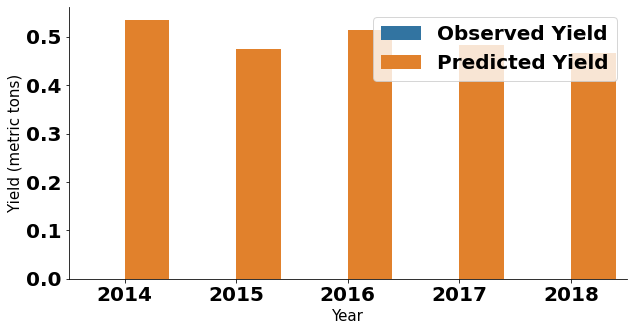

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 5))

sns.barplot(x='year', y='pred_log_yield_ha', hue='data_type', data=yields, ax=ax1, 
#             estimator = sum,
            ci = None
           )
# sns.boxplot(x='Year', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

plt.xlabel("Year", fontsize=15)
plt.ylabel("Yield (metric tons)", fontsize=15)

h, l = ax1.get_legend_handles_labels()
ax1.legend(h, ['Observed Yield', 'Predicted Yield'],loc='upper right')

plt.savefig(f'images/all_yield_pred.png', dpi=300)

In [23]:
# calculate average hectare of crop area
avg_crop_area

# filter for prediction years
pred_summary_future['area_planted_average'] = avg_crop_area
pred_summary_future['yield_mt_ha'] = 10 ** pred_summary_future['pred_log_yield_ha']
pred_summary_future['yield_mt'] = pred_summary_future['area_planted_average'] * pred_summary_future['yield_mt_ha']
# pred_summary_future

/opt/python/3.7.7/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Plot Individual Crop Year (Predictions)

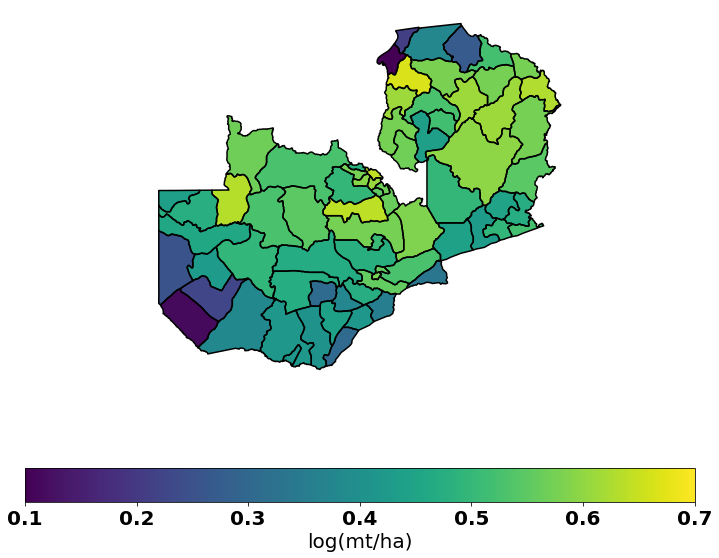

In [24]:
prediction_year = 2017

fig, ax = plt.subplots(figsize = (12,10))
pred_summary_full[pred_summary_full.year == prediction_year].plot(
    column = "pred_log_yield_ha",
    legend = True,
    ax = ax,
    legend_kwds = {'label': 'log(mt/ha)','orientation': 'horizontal'},
    norm=colors.Normalize(vmin=min_val, vmax=max_val)
)

#plt.legend(facecolor='k', labelcolor='w', labels = 'yield_predictions')

country_shp.boundary.plot(ax = ax, edgecolor = "black")
plt.axis('off')

plt.savefig(f'images/yield_predictions_{prediction_year}.png', dpi=300, transparent=True)

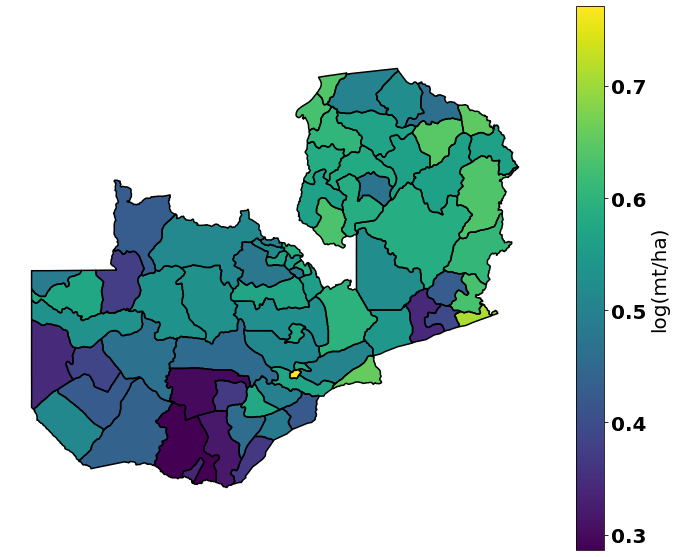

In [25]:
prediction_year = 2020

fig, ax = plt.subplots(figsize = (12,10))
pred_summary_future[pred_summary_future.year == prediction_year].plot(
    column = "pred_log_yield_ha",
    legend = True,
    ax = ax,
    legend_kwds = {'label': 'log(mt/ha)','orientation': 'vertical'},
)

#plt.legend(facecolor='k', labelcolor='w', labels = 'yield_predictions')

country_shp.boundary.plot(ax = ax, edgecolor = "black")
plt.axis('off')

plt.savefig(f'images/yield_predictions_{prediction_year}.png', dpi=300, transparent=True)

## Calculate Yield in Metric Tons

### Import ground-truth data

In [26]:
country_crop = geopandas.GeoDataFrame(crop_df_full.join(country_shp), crs = country_shp.crs)
country_crop

year district  area_planted  area_harvested  expected_pn  yield_mt_ha  \
0    2009  Chadiza    20916.3690      20856.5510   27900.8440     1.333924   
1    2010  Chadiza    19926.2680      17760.4630   36914.2850     1.852544   
2    2011  Chadiza    21878.6990      21293.2830   42951.0390     6.846486   
3    2012  Chadiza    23893.8030      21453.4320   51339.6880     2.148661   
4    2013  Chadiza    24901.4650      23475.9180   50022.2270     2.008807   
..    ...      ...           ...             ...          ...          ...   
729  2014  Zambezi     5598.5332       5040.2520   11869.8720     2.120175   
730  2015  Zambezi     6949.6079       5783.5313   14506.9960     2.087455   
731  2016  Zambezi     6945.7231       6099.7495   11983.4050     1.725293   
732  2017  Zambezi     6649.5347       5109.0869    9910.8359     1.490456   
733  2018  Zambezi     4682.0039       3940.8188    7595.4893     1.622273   

          sales  basal_fert  top_dressing       yield_mt     data_type  \
0     6096.8062  1237.20360    1210.84550   27900.842419  ground_truth   
1    12218.5400  2094.63670    2205.05150   36914.288226  ground_truth   
2    24449.4820  1974.24440    2066.66920  149792.208590  ground_truth   
3    23595.8300  2048.52930    2029.08220   51339.685037  ground_truth   
4    23455.7910  2678.22070    2635.18120   50022.229732  ground_truth   
..          ...         ...           ...            ...           ...   
729   5919.3140   504.96310     506.48303   11869.872367  ground_truth   
730   6705.9492   790.42181     776.12677   14506.995844  ground_truth   
731   6181.8188   588.78760     588.78760   11983.405361  ground_truth   
732   4673.5591   718.82574     704.61713    9910.836231  ground_truth   
733   2000.1896   214.98111     228.23885    7595.488981  ground_truth   

     log_yield geometry  
0     0.368087     None  
1     0.455232     None  
2     0.894675     None  
3     0.498126     None  
4     0.478394     None  
..         ...      ...  
729   0.494179     None  
730   0.489601     None  
731   0.435413     None  
732   0.396279     None  
733   0.418678     None  

[734 rows x 13 columns]

### Join datasets

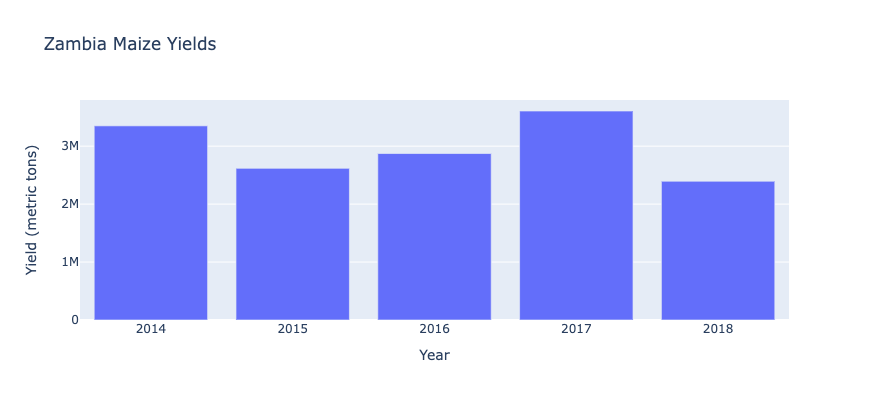

In [27]:
crop_df = crop_df[crop_df.year >= 2014]
district_df = district_df[district_df.year >=2014]

fig = px.bar(district_df, x='year', y='yield_mt',
             labels={'year': 'Year',
                     'yield_mt': 'Yield (metric tons)'},
             title='Zambia Maize Yields',
             
            height=400, width=1000)


fig.show()

<AxesSubplot:xlabel='year', ylabel='yield_mt'>

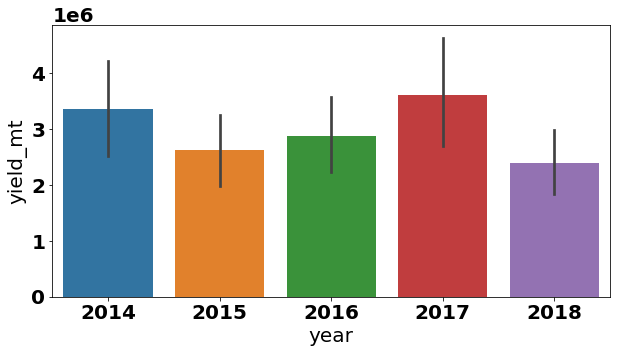

In [28]:
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="yield_mt", data=crop_df, estimator = sum)

## Load Model

In [ ]:
# load model
filename = 'data/results/final_model.sav'

ridge_cv_random_loaded = pickle.load(open(filename, 'rb'))

print(f"Validation R2 performance {ridge_cv_random_loaded.best_score_:0.2f}")

In [ ]:
ridge_cv_random_loaded